<h1 style="font-size:36px; color:green;">📌 1) Import Libraries & Helper Function</h1>


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import csv
from sklearn.decomposition import PCA

# แสดงภาพด้วย matplotlib
def show(img, title=None, size=8):
    plt.figure(figsize=(size, size * img.shape[0] / img.shape[1]))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis("off")
    plt.show()


<h1 style="font-size:36px; color:green;">📌 2) Preprocess → ทำ mask (binary image)</h1>

In [2]:
def preprocess_for_contours(bgr, 
                            blur_ksize=5, 
                            use_adaptive=False, 
                            thr_val=120, 
                            morph_open=3, 
                            morph_close=3,
                            use_watershed=False):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    if blur_ksize > 0:
        gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    if use_adaptive:
        thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 31, 5)
    else:
        _, thr = cv2.threshold(gray, thr_val, 255, cv2.THRESH_BINARY_INV)

    if morph_open > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_open, morph_open))
        thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN, k, iterations=1)

    if morph_close > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_close, morph_close))
        thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, k, iterations=1)

    if not use_watershed:
        return thr

    # Watershed แยกวัตถุเกาะกัน
    dist = cv2.distanceTransform(thr, cv2.DIST_L2, 5)
    dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    _, sure_fg = cv2.threshold((dist_norm * 255).astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    sure_bg = cv2.dilate(thr, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0
    bgr_copy = bgr.copy()
    cv2.watershed(bgr_copy, markers)
    mask = np.where(markers > 1, 255, 0).astype(np.uint8)
    return mask


In [3]:
# เอามาจาก https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e

def reprocess_for_contours(original):
    # แปลงเป็น grayscale
    gray_im = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    # ปรับ contrast ด้วย gamma correction
    gray_correct = np.array(255 * (gray_im / 255.0) ** 1.2, dtype='uint8')

    # Histogram equalization (ถ้าต้องการใช้แทน gray_correct)
    gray_equ = cv2.equalizeHist(gray_im)

    # Adaptive threshold (block size เลือก 51, C=19)
    thresh = cv2.adaptiveThreshold(
        gray_correct, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        51, 19
    )

    # กลับสี (วัตถุ = ขาว)
    thresh = cv2.bitwise_not(thresh)

    # Dilate + Erode
    kernel = np.ones((15, 15), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    img_erode = cv2.erode(img_dilation, kernel, iterations=1)

    # Median filter ล้าง noise
    img_erode = cv2.medianBlur(img_erode, 7)

    return img_erode

<h1 style="font-size:36px; color:green;">📌 3) Find Objects (Connected Components)</h1>

In [4]:
def find_objects_cc(mask, min_area=80, use_rotated=True, pad=2):
    bin_mask = (mask > 0).astype("uint8") * 255
    n, labels, stats, _ = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)
    comps = []
    H, W = bin_mask.shape[:2]
    for i in range(1, n):
        x, y, w, h, area = stats[i]
        if area < min_area: 
            continue
        sub = (labels[y:y+h, x:x+w] == i).astype("uint8") * 255
        rot_box = None
        if use_rotated:
            cs = cv2.findContours(sub, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cs = cs[0] if len(cs) == 2 else cs[1]
            if cs:
                c = max(cs, key=cv2.contourArea)
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box[:,0] += x; box[:,1] += y
                rot_box = box.astype(int)
        comps.append({
            "label": i,
            "area": int(area),
            "bbox": (int(x), int(y), int(w), int(h)),
            "rot_box": rot_box,
            "mask": sub
        })
    comps = sorted(comps, key=lambda c: (c["bbox"][1]//50, c["bbox"][0]))
    return comps


<h1 style="font-size:36px; color:green;">📌 4) Extract Features</h1>

In [5]:
def features_from_components(comps):
    feats = []
    for comp in comps:
        sub = comp["mask"]
        cs = cv2.findContours(sub, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cs = cs[0] if len(cs) == 2 else cs[1]
        if not cs:
            feats.append([0]*13); continue
        c = max(cs, key=cv2.contourArea)
        area = cv2.contourArea(c)
        peri  = cv2.arcLength(c, True)
        x,y,w,h = cv2.boundingRect(c)
        aspect = w / (h + 1e-6)
        circularity = (4*np.pi*area) / (peri**2 + 1e-6)
        hull = cv2.convexHull(c); hull_area = cv2.contourArea(hull) + 1e-6
        solidity = area / hull_area
        eq_diam = np.sqrt(4*area/np.pi)
        hu = cv2.HuMoments(cv2.moments(c)).flatten()
        hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)
        feats.append([area, peri, aspect, circularity, solidity, eq_diam, *hu_log])
    return np.array(feats, dtype=np.float32)


<h1 style="font-size:36px; color:green;">📌 5) Clustering</h1>

In [6]:
def cluster_objects(features, method="kmeans", k=3, dbscan_eps=0.7, dbscan_min_samples=3):
    if features.shape[0] == 0:
        return np.array([])
    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    if method == "kmeans":
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(X)
    else:
        db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
        labels = db.fit_predict(X)
    return labels


In [7]:
def plot_clusters(features, labels, method="kmeans"):
    """
    แสดง clusters โดยใช้ PCA ลดเหลือ 2 มิติ
    """
    if features.shape[0] == 0 or len(set(labels)) <= 1:
        print("⚠️ ไม่มีข้อมูลพอจะแสดง clusters")
        return

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(6,6))
    for lb in set(labels):
        mask = (labels == lb)
        if lb == -1:
            plt.scatter(X2[mask,0], X2[mask,1], label="Noise", alpha=0.6, c="red", marker="x")
        else:
            plt.scatter(X2[mask,0], X2[mask,1], label=f"Class {lb}", alpha=0.7)

    plt.title(f"Cluster visualization ({method})")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.show()

<h1 style="font-size:36px; color:green;">📌 6) Annotate (By Shape)</h1>

In [8]:
def annotate_by_shape(bgr, comps, labels, title=None, save_path=None,
                      mode="mask", alpha=0.35, thickness=3):
    vis = bgr.copy()
    if not comps:
        show(vis, title or "No objects"); 
        return vis, {}

    from collections import Counter
    lbs = labels.astype(int).tolist()
    uniq = sorted(set(lbs))
    rng = np.random.default_rng(123)
    color_map = {lb: tuple(int(x) for x in rng.integers(40, 230, size=3)) for lb in uniq}
    color_map[-1] = (0,0,255)

    H, W = vis.shape[:2]
    overlay = np.zeros_like(vis)

    for comp, lb in zip(comps, lbs):
        color = color_map.get(lb, (255,255,255))
        sub = comp["mask"]                # mask ภายใน ROI
        x, y, w, h = comp["bbox"]         # offset ของ ROI ในภาพใหญ่

        # หา contour หลักในพิกัด local
        cs = cv2.findContours(sub, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cs = cs[0] if len(cs) == 2 else cs[1]
        if not cs:
            continue
        c = max(cs, key=cv2.contourArea)

        if mode == "mask":
            yy, xx = np.where(sub > 0)
            gy = np.clip(yy + y, 0, H-1)  # แปลงเป็นพิกัด global
            gx = np.clip(xx + x, 0, W-1)
            overlay[gy, gx] = color
        elif mode == "contour":
            c_global = c.copy()
            c_global[:,0,0] += x
            c_global[:,0,1] += y
            cv2.drawContours(vis, [c_global], -1, color, thickness)
        elif mode == "hull":
            hull = cv2.convexHull(c)
            hull[:,0,0] += x
            hull[:,0,1] += y
            cv2.polylines(vis, [hull], True, color, thickness)
        else:
            raise ValueError("mode must be 'mask' | 'contour' | 'hull'")

        # centroid (global)
        M = cv2.moments(c)
        cx_local = (M['m10']/(M['m00']+1e-6))
        cy_local = (M['m01']/(M['m00']+1e-6))
        cx = int(cx_local + x)
        cy = int(cy_local + y)

        # ป้าย ID
        text = f"ID {lb}"
        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        bx1, by1 = max(0, cx - tw//2 - 4), max(0, cy - th - 10)
        bx2, by2 = min(W-1, cx + tw//2 + 4), min(H-1, cy - 2)
        cv2.rectangle(vis, (bx1, by1), (bx2, by2), (255,255,255), -1)
        cv2.putText(vis, text, (bx1+3, by2-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    if mode == "mask":
        vis = cv2.addWeighted(overlay, alpha, vis, 1-alpha, 0)

    counts = Counter(lbs)
    legend = " | ".join([f"Class {k}: {v}" for k,v in sorted(counts.items())])
    (lw, lh), _ = cv2.getTextSize(legend, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)  # <-- ปรับขนาด text ที่นี่
    cv2.rectangle(vis, (10, H-lh-20), (10+lw+10, H-10), (30,30,30), -1)
    cv2.putText(vis, legend, (15, H-15),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,        # <-- ลดขนาด font
                (80,255,80),
                1,          # <-- ลดความหนาเส้น
                cv2.LINE_AA)

    if save_path:
        cv2.imwrite(save_path, vis)
    show(vis, title or f"Annotated ({mode})")
    return vis, counts



<h1 style="font-size:36px; color:green;">📌 7) Main Pipeline for test</h1>

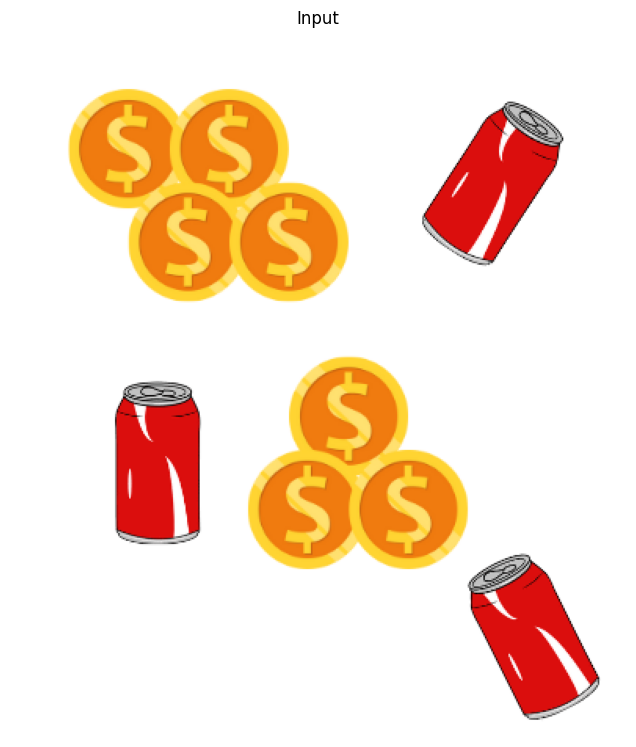

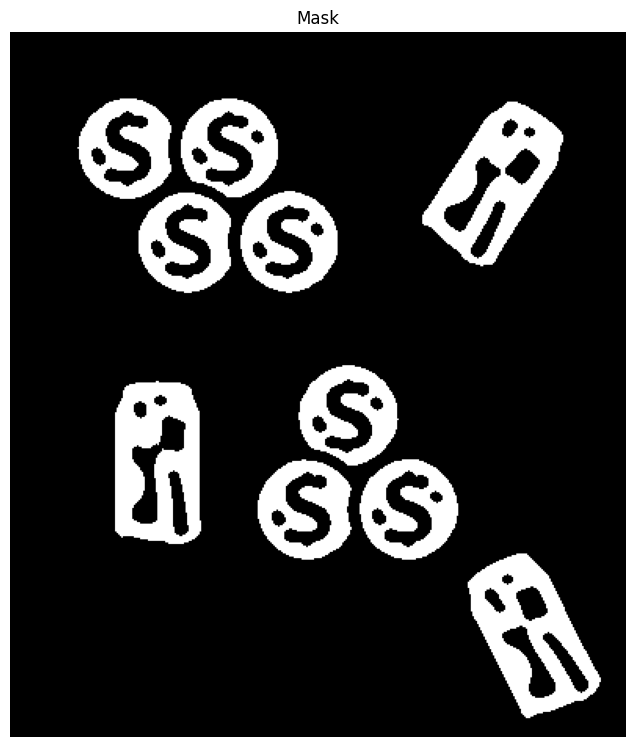

พบวัตถุ 10 ชิ้น


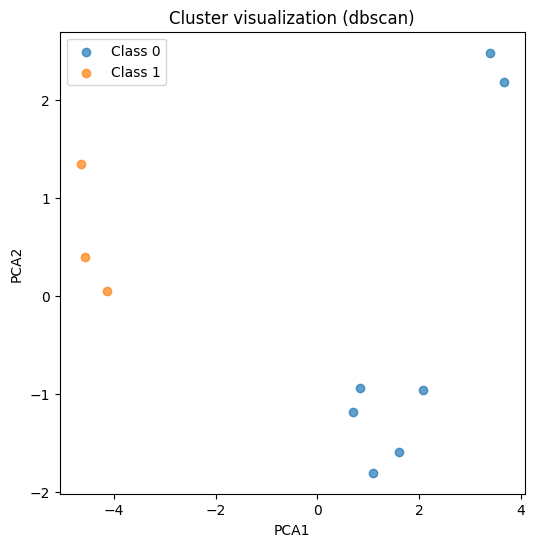

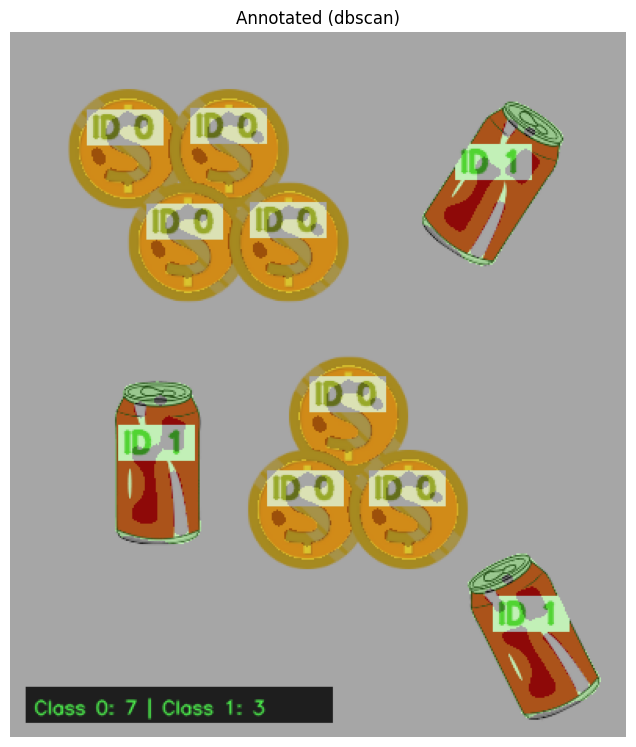

Counts by class: {0: 7, 1: 3}
บันทึกฟีเจอร์ที่ features_test.csv, ภาพ annotate ที่ annot_test.png


In [9]:
#METHOD = "kmeans"    
METHOD = "dbscan"  
k = 2  # ปรับจำนวน cluster ตามกลุ่มในภาพสำหรับ kmeans

DBSCAN_EPS = 4  # ปรับขนาดรัศมีของจุดที่อยู่ใกล้กัน
DBSCAN_MIN_SAMPLES = 2 # กำหนดให้ในกลุ่มที่อยู่ใกล้กันต้องมีกี่จุดถึงนับเป็น 1 cluster

USE_WATERSHED = False
THRESH_VAL = 120
OUTPUT_ANNOTATED = "annot_test.png"
OUTPUT_CSV = "features_test.csv"

# Load image
img = cv2.imread("test4.png") # เลือกรูป
assert img is not None, "ไม่พบรูป"

# เตรียมภาพแบบ 1 สำหรับให้ภายในภาพแปลงออกมาแล้วเต็ม
#mask = reprocess_for_contours(img)

# เตรียมภาพแบบ 2 สำหรับ object ที่ติดกัน 
mask = preprocess_for_contours(
    img,
    blur_ksize=7,
    use_adaptive=True,
    thr_val=THRESH_VAL,
    morph_open=3,
    morph_close=7,
    use_watershed=USE_WATERSHED
)


show(img, "Input")
show(mask, "Mask")

# Find objects
comps = find_objects_cc(mask, min_area=120, use_rotated=True, pad=3)
print(f"พบวัตถุ {len(comps)} ชิ้น")

# Features
features = features_from_components(comps)
# print("features shape:", features.shape)

# Clustering
if METHOD == "kmeans":
    labels = cluster_objects(features, method="kmeans", k=k)
    plot_clusters(features, labels, method="kmeans")
else:
    labels = cluster_objects(features, method="dbscan",
                             dbscan_eps=DBSCAN_EPS,
                             dbscan_min_samples=DBSCAN_MIN_SAMPLES)
    plot_clusters(features, labels, method="dbscan")

# Annotate
annotated, counts = annotate_by_shape(
    img, comps, labels,
    mode="mask",
    alpha=0.35,
    title=f"Annotated ({METHOD})",
    save_path=OUTPUT_ANNOTATED
)
print("Counts by class:", dict(counts))

# Save CSV
cols = ["idx","x","y","w","h","label","area","perimeter","aspect","circularity","solidity","eq_diam"] + [f"hu{i+1}" for i in range(7)]
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(cols)
    for i, (comp, lb, row) in enumerate(zip(comps, labels, features)):
        x,y,w,h = comp["bbox"]
        area, peri, aspect, circularity, solidity, eq_diam, *hu = row.tolist()
        writer.writerow([i,x,y,w,h,int(lb),area,peri,aspect,circularity,solidity,eq_diam,*hu])
print(f"บันทึกฟีเจอร์ที่ {OUTPUT_CSV}, ภาพ annotate ที่ {OUTPUT_ANNOTATED}")
